## Stochastic Integration Methods

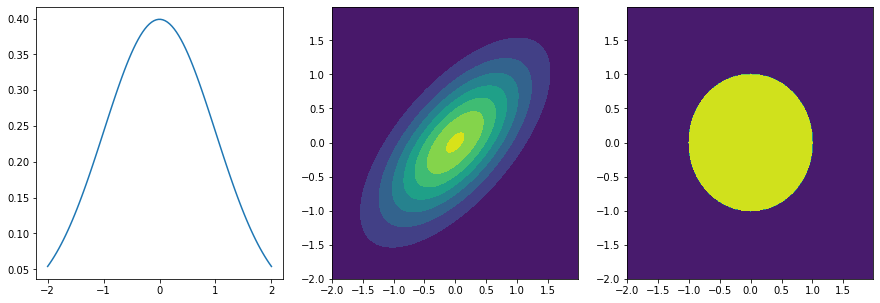

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import multivariate_normal

g1D_0 = multivariate_normal(0, 1)
g2D_0 = multivariate_normal([0, 0], [[0.6, 0.4],[0.4, 0.6]])
circ1 = lambda x : np.greater_equal(1, x[..., 0]**2 + x[..., 1]**2).astype(int)

x = np.linspace(-2,2,100)
x2D, y2D = np.mgrid[-2:2:.01, -2:2:.01]
pos = np.array((x2D,y2D)).transpose((1,2,0))
fig, ax = plt.subplots(ncols=3, figsize=(15, 5))
ax[0].plot(x, g1D_0.pdf(x))
ax[1].contourf(x2D, y2D, g2D_0.pdf(pos))
ax[2].contourf(x2D, y2D, circ1(pos));

### Uniform Sampling

1. Choose cube that encloses the integration domain
2. Sample uniform random points inside cube, evaluate function
3. Compute function average, multiply by volume of the cube

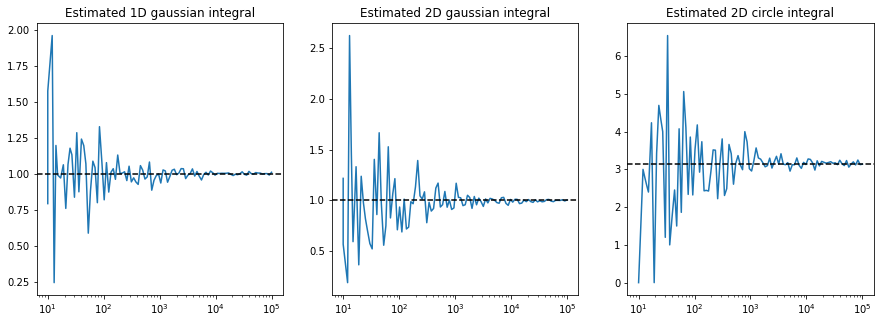

CPU times: user 1.84 s, sys: 926 ms, total: 2.76 s
Wall time: 954 ms


In [21]:
%%time
def int_uniform(f, xmin, xmax, N):
    x_arr = np.random.uniform(xmin, xmax, (N, len(xmin)))
    return np.mean(f(x_arr)) * np.prod(np.array(xmax) - np.array(xmin))

Nlst = (10**np.linspace(1, 5, 100)).astype(int)
I1 = [int_uniform(g1D_0.pdf, [-5], [5], N) for N in Nlst]
I2 = [int_uniform(g2D_0.pdf, [-3, -3], [3, 3], N) for N in Nlst]
I3 = [int_uniform(circ1, [-3, -3], [3, 3], N) for N in Nlst]

fig, ax = plt.subplots(ncols=3, figsize=(15,5))
ax[0].semilogx(Nlst, I1)
ax[1].semilogx(Nlst, I2)
ax[2].semilogx(Nlst, np.array(I3))
ax[0].axhline(y=1.0, linestyle='--', color='black')
ax[1].axhline(y=1.0, linestyle='--', color='black')
ax[2].axhline(y=np.pi, linestyle='--', color='black')
ax[0].set_title('Estimated 1D gaussian integral')
ax[1].set_title('Estimated 2D gaussian integral')
ax[2].set_title('Estimated 2D circle integral')
plt.show()

### Importance Sampling

Same as uniform, but sample from arbitrary distribution $Q(x)$. Normalize each point by pdf $Q(x)$ at that point. For uniform distribution $Q(x) = \frac{1}{V_{\square}}$ reduces to uniform sampling.

$$\int_{\Omega} f(x)d^nx \approx \frac{1}{N} \sum_{i=1}^{N} \frac{f(x_i)}{Q[x_i]} \;\; \mathrm{s.t.} \; x_i \sim Q_{\Omega}$$

If the distribution function is known, but it is not easy to sample from it, Metropolis-Hastings can be used to construct samples used to evaluate $f(x_i)$ and $q(x_i)$

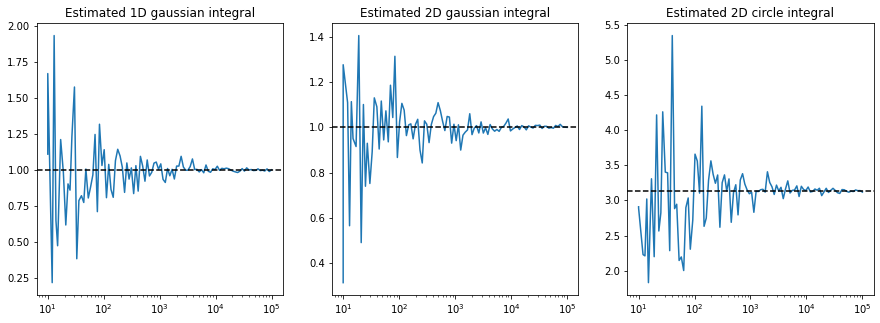

CPU times: user 2.96 s, sys: 2.12 s, total: 5.08 s
Wall time: 1.41 s


In [22]:
%%time
def int_importance(f, qdist, qf, N):
    x_arr = qdist(N)
    return np.mean(np.divide(f(x_arr), qf(x_arr)))

# Use gaussian sampling function
m1D, s1D = 0, 5
m2D, s2D = [0, 0], np.diag([2, 2])
qdist_g_1D = lambda N : np.random.normal(m1D, s1D, N)
qdist_g_2D = lambda N : np.random.multivariate_normal(m2D, s2D, N)
qf_g_1D = multivariate_normal(m1D, s1D**2).pdf
qf_g_2D = multivariate_normal(m2D, s2D).pdf

Nlst = (10**np.linspace(1, 5, 100)).astype(int)
I1 = [int_importance(g1D_0.pdf, qdist_g_1D, qf_g_1D, N) for N in Nlst]
I2 = [int_importance(g2D_0.pdf, qdist_g_2D, qf_g_2D, N) for N in Nlst]
I3 = [int_importance(circ1, qdist_g_2D, qf_g_2D, N) for N in Nlst]

fig, ax = plt.subplots(ncols=3, figsize=(15,5))
ax[0].semilogx(Nlst, I1)
ax[1].semilogx(Nlst, I2)
ax[2].semilogx(Nlst, np.array(I3))
ax[0].axhline(y=1.0, linestyle='--', color='black')
ax[1].axhline(y=1.0, linestyle='--', color='black')
ax[2].axhline(y=np.pi, linestyle='--', color='black')
ax[0].set_title('Estimated 1D gaussian integral')
ax[1].set_title('Estimated 2D gaussian integral')
ax[2].set_title('Estimated 2D circle integral')
plt.show()

### Adaptive integration via MCMC
* Logic is that the importance function Q is adapted based on current samples
* Apparently Hard and still not well understood
* Examples include VEGAS algorithm
* http://statweb.stanford.edu/~owen/pubtalks/AdaptiveISweb.pdf